In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split,KFold,cross_val_score,StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve,average_precision_score

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [3]:
col_names=['animal_name','hair','feathers','eggs','milk','airborne','aquatic','predator','toothed','backbone',
           'breathes','venomous','fins','legs','tail','domestic','catsize','type']
data = pd.read_csv('zoo.data',header=None,names=col_names)

In [4]:
data.isnull().sum()

animal_name    0
hair           0
feathers       0
eggs           0
milk           0
airborne       0
aquatic        0
predator       0
toothed        0
backbone       0
breathes       0
venomous       0
fins           0
legs           0
tail           0
domestic       0
catsize        0
type           0
dtype: int64

In [5]:
data.describe()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.425743,0.198020,0.584158,0.405941,0.237624,0.356436,0.554455,0.603960,0.821782,0.792079,0.079208,0.168317,2.841584,0.742574,0.128713,0.435644,2.831683
std,0.496921,0.400495,0.495325,0.493522,0.427750,0.481335,0.499505,0.491512,0.384605,0.407844,0.271410,0.376013,2.033385,0.439397,0.336552,0.498314,2.102709
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,2.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,7.000000


1    41
2    20
4    13
7    10
6     8
3     5
5     4
Name: type, dtype: int64


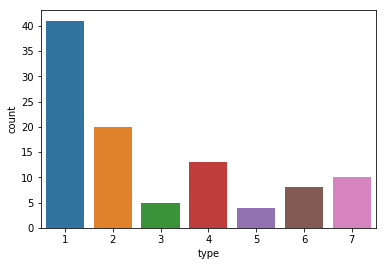

In [6]:
print(data['type'].value_counts())
sns.countplot(data['type'])

In [7]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
hair,1,-0.43,-0.82,0.88,-0.2,-0.47,-0.15,0.49,0.19,0.44,-0.1,-0.28,0.39,0.049,0.21,0.46,-0.56
feathers,-0.43,1,0.42,-0.41,0.66,-0.059,-0.1,-0.61,0.23,0.25,-0.15,-0.22,-0.21,0.29,0.032,-0.14,-0.2
eggs,-0.82,0.42,1,-0.94,0.38,0.38,0.012,-0.64,-0.34,-0.38,0.099,0.16,-0.22,-0.22,-0.16,-0.51,0.66
milk,0.88,-0.41,-0.94,1,-0.37,-0.36,-0.03,0.63,0.38,0.42,-0.24,-0.16,0.21,0.21,0.16,0.57,-0.72
airborne,-0.2,0.66,0.38,-0.37,1,-0.17,-0.3,-0.59,-0.1,0.29,0.0085,-0.25,0.044,0.0095,0.063,-0.35,0.023
aquatic,-0.47,-0.059,0.38,-0.36,-0.17,1,0.38,0.053,0.022,-0.64,0.088,0.6,-0.36,-0.035,-0.22,-0.11,0.33
predator,-0.15,-0.1,0.012,-0.03,-0.3,0.38,1,0.13,0.051,-0.26,0.12,0.19,-0.1,0.019,-0.31,0.14,0.061
toothed,0.49,-0.61,-0.64,0.63,-0.59,0.053,0.13,1,0.58,-0.066,-0.062,0.36,-0.19,0.31,0.069,0.34,-0.47
backbone,0.19,0.23,-0.34,0.38,-0.1,0.022,0.051,0.58,1,0.21,-0.25,0.21,-0.43,0.73,0.1,0.36,-0.83
breathes,0.44,0.25,-0.38,0.42,0.29,-0.64,-0.26,-0.066,0.21,1,-0.12,-0.62,0.37,0.089,0.12,0.2,-0.52


In [8]:
#drop highly correlated features
data = data.drop(['hair','eggs'],axis=1)

X = data.drop(['animal_name','type'],axis=1).values
y = data['type'].values


In [9]:
def train_AP_acc(classifier,X,y):
    k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    
    average_precision_per_fold = dict()
    precision = dict()
    recall = dict()
    accuracy = []
    j=0 #count folds
    for train_idx,test_idx in k_fold.split(X,y):
        j = j+1;
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        y_train = label_binarize(y_train, classes=[1, 2, 3, 4, 5, 6, 7])
        y_test = label_binarize(y_test, classes=[1, 2, 3, 4, 5, 6, 7])

        classifier.fit(X_train, y_train)
        y_score = classifier.decision_function(X_test)

        predict = classifier.predict(X_test)
        acc = accuracy_score(y_test,predict)

        
        average_precision = dict()
        accuracy.append(acc)

        for i in range(7):
            average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
        
        precision["fold_"+str(j)], recall["fold_"+str(j)], _ = precision_recall_curve(y_test.ravel(),y_score.ravel())

    
        average_precision_per_fold["fold_"+str(j)] = average_precision
    
    return average_precision_per_fold, np.mean(accuracy), precision, recall


In [10]:
def plot_pr_curve(precision,recall,name,title):
    plt.clf()
    plt.plot(recall, precision,label='micro-average Precision-recall curve (area = {0:0.2f})')
    plt.title(title)
    plt.savefig(name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

In [11]:
def print_AP_acc(AP,acc):
    print("Average Precision:")
    print("Fold_1: ",AP['fold_1'])
    print("Fold_2: ",AP['fold_2'])
    print("Fold_3: ",AP['fold_3'])
    print("Fold_4: ",AP['fold_4'])
    print("Fold_5: ",AP['fold_5'])
    
    print("Classification Accuracy:")
    print(acc)


Average Precision:
Fold_1:  {0: 1.0000000000000002, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 0.8333333333333333}
Fold_2:  {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 0.8333333333333333, 6: 0.5833333333333334}
Fold_3:  {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}
Fold_4:  {0: 1.0, 1: 1.0, 2: 0.06666666666666667, 3: 1.0, 4: nan, 5: 1.0, 6: 1.0}
Fold_5:  {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}
Classification Accuracy:
0.9018834966203387


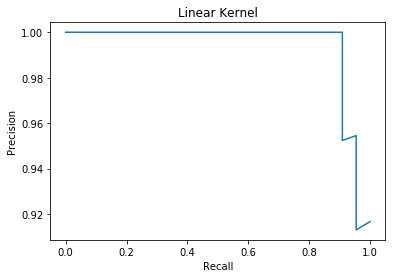

In [14]:
linear_svm = OneVsRestClassifier(svm.SVC(C=0.5,kernel='linear', probability=True))

AP_per_class_linear, clf_accuracy_linear, precision_linear, recall_linear = train_AP_acc(linear_svm,X,y)

print_AP_acc(AP_per_class_linear,clf_accuracy_linear)
plot_pr_curve(precision_linear['fold_1'],recall_linear['fold_1'],'linear1.png','Linear Kernel')

Average Precision:
Fold_1:  {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}
Fold_2:  {0: 1.0, 1: 1.0, 2: 0.08333333333333333, 3: 1.0, 4: nan, 5: 1.0, 6: 1.0}
Fold_3:  {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}
Fold_4:  {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}
Fold_5:  {0: 1.0, 1: 1.0, 2: 0.5, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}
Classification Accuracy:
0.9006652996126681


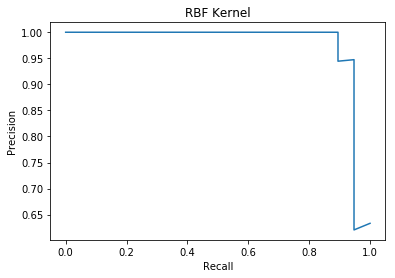

In [15]:
rbf_svm = OneVsRestClassifier(svm.SVC(C=1.25,kernel='rbf'))

AP_per_class_rbf, clf_accuracy_rbf, precision_rbf, recall_rbf = train_AP_acc(rbf_svm,X,y)

print_AP_acc(AP_per_class_rbf,clf_accuracy_rbf)
plot_pr_curve(precision_rbf['fold_5'],recall_rbf['fold_5'],'rbf1.png','RBF Kernel')

In [16]:
poly_svm = OneVsRestClassifier(svm.SVC(C=1.0,kernel='poly'))

AP_per_class_poly, clf_accuracy_poly, precision_poly, recall_poly = train_AP_acc(poly_svm,X,y)

print_AP_acc(AP_per_class_poly,clf_accuracy_poly)

# plot_pr_curve(precision_poly['fold_5'],recall['fold_5'])

Average Precision:
Fold_1:  {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 0.8333333333333333}
Fold_2:  {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 0.8333333333333333}
Fold_3:  {0: 1.0, 1: 1.0, 2: 0.3333333333333333, 3: 1.0, 4: 1.0, 5: 0.5833333333333333, 6: 1.0}
Fold_4:  {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: nan, 5: 1.0, 6: 1.0}
Fold_5:  {0: 1.0, 1: 1.0, 2: 0.5, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}
Classification Accuracy:
0.6892154628996734


Average Precision:
Fold_1:  {0: 0.6500712250712251, 1: 0.32916666666666666, 2: 0.05263157894736842, 3: 1.0, 4: 0.14285714285714285, 5: 0.08496732026143791, 6: 0.5555555555555556}
Fold_2:  {0: 0.5551406926406927, 1: 0.2714285714285714, 2: 1.0, 3: 1.0, 4: 0.09090909090909091, 5: 0.125, 6: 0.6}
Fold_3:  {0: 0.7378968253968254, 1: 0.25151515151515147, 2: 1.0, 3: 1.0, 4: 0.125, 5: 0.10989010989010989, 6: 0.3125}
Fold_4:  {0: 0.7318813131313131, 1: 0.28154761904761905, 2: 0.1, 3: 1.0, 4: 0.16666666666666666, 5: 0.06666666666666667, 6: 0.25757575757575757}
Fold_5:  {0: 0.5651515151515152, 1: 0.3654761904761905, 2: 1.0, 3: 1.0, 4: nan, 5: 0.07692307692307693, 6: 0.08496732026143791}
Classification Accuracy:
0.47627401837928146


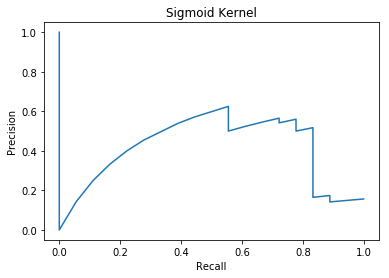

In [17]:
sigmoid_svm = OneVsRestClassifier(svm.SVC(C=1.5,kernel='sigmoid'))

AP_per_class_sigmoid, clf_accuracy_sigmoid, precision_sigmoid, recall_sigmoid = train_AP_acc(sigmoid_svm,X,y)

print_AP_acc(AP_per_class_sigmoid,clf_accuracy_sigmoid)

plot_pr_curve(precision_sigmoid['fold_5'],recall_sigmoid['fold_5'],'sigmoid1.png','Sigmoid Kernel')